In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from IPython import display
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class DiscriminatorNet(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.dense2 = nn.Linear(512,256)
        self.dense3 = nn.Linear(256,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        z = self.flatten(x)
        z = F.leaky_relu(self.dense(z),0.2)
        z = F.dropout(z, 0.3)
        z = F.leaky_relu(self.dense2(z),0.2)
        z = F.dropout(z, 0.3)
        z = F.leaky_relu(self.dense3(z),0.2)
        z = F.dropout(z, 0.3)
        z = self.sigmoid(z)
        return z
    

class GeneratorNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.dense = nn.Linear(d,256)
        self.dense2 = nn.Linear(256,512)
        self.dense3 = nn.Linear(512,784)
    
    def forward(self, z):
        x = F.leaky_relu(self.dense(z),0.2)
        x = F.leaky_relu(self.dense2(x),0.2)
        x = torch.tanh(self.dense3(x))
        return x

In [5]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    prediction_fake = discriminator(fake_data)

    loss = -(torch.mean(prediction_real)-torch.mean(prediction_fake))
    loss.backward()

    optimizer.step()
    
    for p in discriminator.parameters():
        p.data.clamp_(-clip_value, clip_value)

    return -loss

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = -torch.mean(prediction)
    loss.backward()

    optimizer.step()

    return loss

In [6]:
def val():
    d = 10
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    gen_imgs = generator(z_random).view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [7]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet(d=10).to(device)

# Optimizers
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

# Number of steps to apply to the discriminator
d_steps = 5  # In Arjovsky et. al 2017 this variable is assigned to 5
# Number of epochs
num_epochs = 201

clip_value = 0.01

0 D: 0.08064280694990016 G: -0.5662490231141861


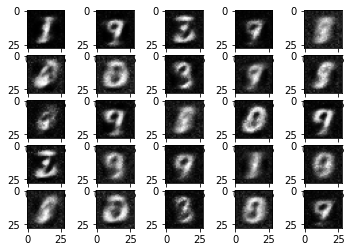

1 D: 0.07488107216129425 G: -0.5534523088794782
2 D: 0.07816401745464756 G: -0.5384576762917199
3 D: 0.0793988086775676 G: -0.5358804674036721
4 D: 0.07869024421614625 G: -0.5365172989332854
5 D: 0.07564248100780983 G: -0.5366234671332435
6 D: 0.07185984529666047 G: -0.5392629985870329
7 D: 0.06863306987006018 G: -0.5392256844272492
8 D: 0.06533872905824739 G: -0.5384730465376555
9 D: 0.06307422298866548 G: -0.5399549514500063
10 D: 0.06111572007380569 G: -0.5398390978129942
11 D: 0.058786258361995344 G: -0.5398778909050834
12 D: 0.05647334800854421 G: -0.5412827332390905
13 D: 0.05468645230539318 G: -0.5410458017259773
14 D: 0.05294916833133331 G: -0.5419968878155323
15 D: 0.05154949347855948 G: -0.5420358956241405
16 D: 0.04968823730818498 G: -0.5403534002395581
17 D: 0.048825195603279165 G: -0.5423808386330919
18 D: 0.0475585730599442 G: -0.5439423219735688
19 D: 0.04627149549882804 G: -0.5444828165111257
20 D: 0.044419136433713216 G: -0.5436658424609251
21 D: 0.04267712923001125 G:

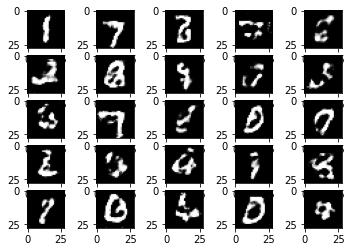

51 D: 0.02598040607183981 G: -0.5527132111571745
52 D: 0.025468156891845183 G: -0.5520296223890553
53 D: 0.025629326427923337 G: -0.5531472648893084
54 D: 0.02515422609060812 G: -0.5520832006102686
55 D: 0.024763279047602022 G: -0.5526388922988225
56 D: 0.02466166764180035 G: -0.5568339290903576
57 D: 0.024441258434547797 G: -0.5558173686964933
58 D: 0.02410742227456717 G: -0.5556295605610683
59 D: 0.02371288118586103 G: -0.5531739460379839
60 D: 0.02366881680641093 G: -0.5561477788475785
61 D: 0.023486696580833973 G: -0.5544607453763104
62 D: 0.023327583722722554 G: -0.5543610065984828
63 D: 0.02315650794551825 G: -0.5558547971091037
64 D: 0.022825515435448588 G: -0.5566055874453425
65 D: 0.02269804933940424 G: -0.5571111627479097
66 D: 0.022200637916003716 G: -0.5528703795821428
67 D: 0.022339306635134764 G: -0.5554375165561115
68 D: 0.022164813694415062 G: -0.5561997598168184
69 D: 0.022223930241965027 G: -0.5581339255833169
70 D: 0.021556620633424218 G: -0.5568088679425498
71 D: 0.

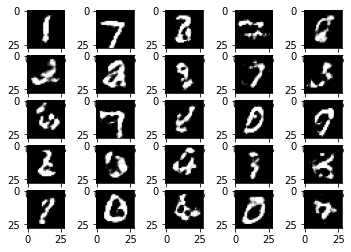

101 D: 0.018225205224205943 G: -0.5641681277421492
102 D: 0.018019941951166085 G: -0.5635535095546291
103 D: 0.018146692816890887 G: -0.5662824420024083
104 D: 0.017866856558744842 G: -0.5637857592436296
105 D: 0.01790149087336526 G: -0.5629568534619265
106 D: 0.018122918976903723 G: -0.568026273362418
107 D: 0.018056472799162875 G: -0.5673238802820381
108 D: 0.01775206439276494 G: -0.5680567523055493
109 D: 0.017577031985528943 G: -0.5639986611886828
110 D: 0.01771933231780778 G: -0.5676485392838907
111 D: 0.01766125558535936 G: -0.5654005629421551
112 D: 0.017511445093256577 G: -0.5645308654699752
113 D: 0.017764624273344905 G: -0.5655786265442366
114 D: 0.01762121890399502 G: -0.5672149046906022
115 D: 0.017509197578755523 G: -0.5691811560567762
116 D: 0.016933588610529137 G: -0.5639775305160327
117 D: 0.017357210970636625 G: -0.5673411205125007
118 D: 0.017348287329236583 G: -0.5674823691595846
119 D: 0.01754443546348035 G: -0.569408709687719
120 D: 0.01728330583714727 G: -0.567216

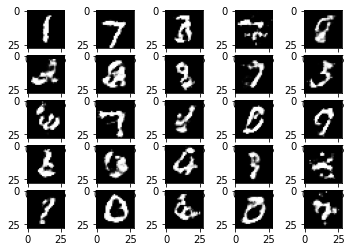

151 D: 0.016144864798100518 G: -0.5732699281244136
152 D: 0.015938904366767738 G: -0.5716613315061719
153 D: 0.016067476465757975 G: -0.5745151358118443
154 D: 0.015574316963203935 G: -0.5729648085799552
155 D: 0.015601429578337843 G: -0.5713738378431243
156 D: 0.015824504015542296 G: -0.5779900267434273
157 D: 0.015759662219456263 G: -0.5762052222101419
158 D: 0.01577555169937199 G: -0.5760873652724569
159 D: 0.015385810830699865 G: -0.5717085252946882
160 D: 0.015571489847545177 G: -0.5757149891304308
161 D: 0.015575894872262788 G: -0.5734463646721992
162 D: 0.015396860235535513 G: -0.5719754492550262
163 D: 0.015697602117493718 G: -0.5736280566593731
164 D: 0.015457968594931336 G: -0.5746648822511945
165 D: 0.015588904583632057 G: -0.5751959075297374
166 D: 0.015220753495881298 G: -0.5710783710103553
167 D: 0.015549844414440553 G: -0.5747010321505288
168 D: 0.015556548500874403 G: -0.5729826753581765
169 D: 0.015582831429520142 G: -0.5756861056600299
170 D: 0.015162998984363288 G: -

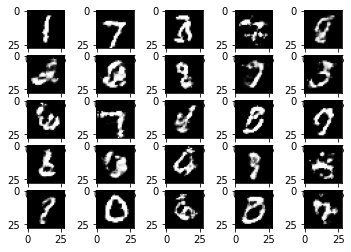

In [8]:
gen_loss = []
dis_loss = []

for epoch in range(num_epochs):
    g_loss = []
    d_loss = []

    for n_batch, (real_batch,_) in enumerate(train_loader):
        for k in range(d_steps):
            # Train Discriminator
            real_data = real_batch.view(-1,28*28).to(device)
            fake_data = generator(torch.randn(real_data.size(0), 10, device=device)).detach()        
            l_d = train_discriminator(d_optimizer, real_data, fake_data)

            d_loss.append(l_d.item())

        # Train Generator
        fake_data = generator(torch.randn(real_batch.size(0), 10, device=device)) #, requires_grad=True))
        l_g = train_generator(g_optimizer, fake_data)

        g_loss.append(l_g.item())

    print(epoch, "D:", np.mean(d_loss), "G:", np.mean(g_loss))
    gen_loss.append(np.mean(g_loss))
    dis_loss.append(np.mean(d_loss))

    if epoch % 50 == 0:
        val()


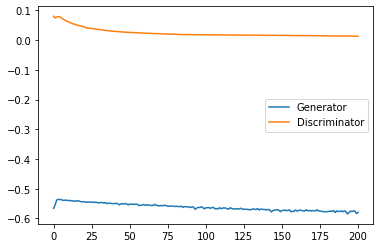

In [9]:
plt.plot(gen_loss, label="Generator")
plt.plot(dis_loss, label="Discriminator")
plt.legend()
plt.show()

To do:
- Quantitative Measures